# Object Detection Demo: Safety Gear Detection



This is a sample reference implementation to showcase object detection (safety gear in this case) with single-shot detection (SSD) and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete, continuing to do things on the host while inference accelerator is busy. 
Specifically, this code demonstrates two parallel inference requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of frame capture.

## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. 
A job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Vision Processing Unit(VPU) or Intel® Arria® 10 FPGA.
After the inference is completed, the output videos are appropriately stored in the /results directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter Notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

### 0.2  (Optional-step): Original video without inference

If you are curious to see the input video, run the following cell to view the original video stream used for inference and object detection.

In [2]:
!ln -sf /data/reference-sample-data/safety-gear-detection/Safety_Full_Hat_and_Vest.mp4
videoHTML('Workers video', ['Safety_Full_Hat_and_Vest.mp4'])

## Step 1: Using Intel® Distribution of OpenVINO™ toolkit

First, let's try running inference on a single image to see how Intel® Distribution of OpenVINO™ toolkit works.
We will be using Intel® Distribution of OpenVINO™ toolkit's Inference Engine (IE) to detect safety gear (hat, vest, etc).
There are five steps involved in this task:

1. Create an Intermediate Representation (IR) Model using the Model Optimizer from Intel
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

The Model Optimizer from Intel creates Intermediate Representation (IR) models that are optimized for different end-point target devices.
These models can be created from existsing DNN models from popular frameworks (e.g. Caffe*, TF) using the Model Optimizer from Intel. 

The Intel® Distribution of OpenVINO™ toolkit includes an utility script `model_downloader.py` that you can use to download some common modes. Run the following cell to see the models available through `model_downloader.py`

In [3]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
face-reidentification-retail-0095
facial-landmarks-35-adas-0002
gaze-estimation-adas-0002
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
image-retrieval-0001
inceptionv3-int8-sparse-v1-tf-0001
inceptionv3-int8-sparse-v2-tf-0001
inceptionv3-int8-tf-0001
instance-segmentation-security-0010
instance-segmentation-security-0050
instance-segmentation-security-0083
landmarks-regression-retail-0009
license-plate-recognition-barrier-0001
mobilenetv2-int8-sparse-v1-tf-0001
mobilenetv2-int8-sparse-v2-tf-0001
mobilenetv2-int8-tf-0001
pedestrian-and-vehicle-detector-adas-0001
pedestrian-detection-adas-0002
pedestrian-detection-a

**Note:** The '!' is a special Jupyter Notebook command that allows you to run shell commands as if you are in command line. So, the above command will work straight out of the box on in a terminal (with '!' removed).

To download a specific model, run the model downloader while specifing the input arguments as follows:
* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will be created for you.

There are more arguments to this script and you can get the full list using the `-h` option.

For example, to download the **mobilenet-ssd** model into **raw_models** directory, run the following cell.

**Note**: This model downloaded will not be used for the demo

In [4]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o raw_models

################|| Downloading models ||################

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 50224 KB/s, 0 seconds passed

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22339 KB/s, 1 seconds passed

################|| Post-processing ||################



**For this demo**, we will use an existing Caffe model specially trained for detecting people, hardhats and safety vests.
Let's convert the model using the model optimizer.

In [5]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model /data/reference-sample-data/safety-gear-detection/worker_safety_mobilenet.caffemodel \
--model_name mobilenet-ssd \
--data_type FP32 \
-o models/mobilenet-ssd/FP32

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/reference-sample-data/safety-gear-detection/worker_safety_mobilenet.caffemodel
	- Path for generated IR: 	/home/u19892/Downloads/R3_upgrade/iot-devcloud/python/safety-gear-detection-python/models/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/front

**Note**: The above line is a single command line input, which spans 4 lines thanks to the backslash '\\', which is a line continuation character in Bash.

Here, the arguments are:
* --input-model : the original model
* --data_type : Data type to use. One of {FP32, FP16, half, float}
* -o : output directory

This script also supports `-h` that will you can get the full list of arguments.

With the `-o` option set as above, this command will write the output to the directory `models/mobilenet-ssd/FP32`

There are two files produced:
```
models/mobilenet-ssd/FP32/mobilenet-ssd.xml
models/mobilenet-ssd/FP32/mobilenet-ssd.bin
```
These will be used later in the exercise.

We will also be needing the FP16 version of the model for the calculations on the MYRIAD architecture. Run the following cell to create it.

In [6]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model /data/reference-sample-data/safety-gear-detection/worker_safety_mobilenet.caffemodel \
--model_name mobilenet-ssd \
--data_type FP16 \
-o models/mobilenet-ssd/FP16 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/reference-sample-data/safety-gear-detection/worker_safety_mobilenet.caffemodel
	- Path for generated IR: 	/home/u19892/Downloads/R3_upgrade/iot-devcloud/python/safety-gear-detection-python/models/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/front

### 1.2 Choosing Device

Now we must select the device used for inferencing. This is done by loading the appropriate plugin to initialize the specified device and load the extensions library (if specified) provided in the extension/ folder for the device.


The following cell constructs **`IEPlugin`**:

In [7]:
from openvino.inference_engine import IEPlugin

def createPlugin(device, extension_list):
    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device=device)

    # Loading additional exension libraries for the CPU
    for extension in extension_list:
        plugin.add_cpu_extension('/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so')
    
    return plugin

**Note**:
Currently, five types of plugins are supported: CPU, GPU, MYRIAD, HDDL and HETERO:FPGA,CPU. CPU plugin may require additional extensions to improve performance, add_cpu_extension function is used to load these additional extensions.




### 1.3 Read the IR (Intermediate Representation) model

We can import optimized models (weights) from step 1.1 into our neural network using **`IENetwork`**. 


In [8]:
from openvino.inference_engine import IENetwork

def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.
    net = IENetwork(model=model_xml, weights=model_bin)
    
    # Some layers in IR models may be unsupported by some plugins. 
    if "CPU" in plugin.device:
        supported_layers = plugin.get_supported_layers(net)
        not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
        if len(not_supported_layers) != 0:
            print("Following layers are not supported by the plugin for specified device {}:\n {}".
                      format(plugin.device, ', '.join(not_supported_layers)))
            print("Please try to specify cpu extensions library path in sample's command line parameters "
                  "using -l or --cpu_extension command line argument")
            return None
    return net

**Note**:
Some models may be incompatible with some target devices. For example, some types of neural network layers are not supported on the CPU target. 

### 1.4 Load the network into the plugin

Once we have the plugin and the network, we can load the network into the plugin using **`plugin.load`**.

In [9]:
def loadNetwork(plugin, net):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=2)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    return exec_net,input_blob,out_blob


### 1.5 Run inference

Now we are ready to try running the inference workload using the plugin.
First let's load the image using OpenCV.
We will also have to do some shape manipulation to convert the image to a format that is compatible with our network


In [10]:
import cv2

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv2.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv2.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    return in_frame.reshape((n, c, h, w)),frame

For the inference, we will be running in **async_mode** by using `start_async` method. 
With the async_mode, the inference is started in parallel on either a separate thread or device.
In other words, `start_async` is non-blocking and the main process is free to do any additional processing needed. 
In the next section, we will see an implementation of pipelining to mask the latency of loading and modifying images.

During asynchronous runs, the different images are tracked by an integer `request_id`. 
Because we only have one image to process, we will just use 0.

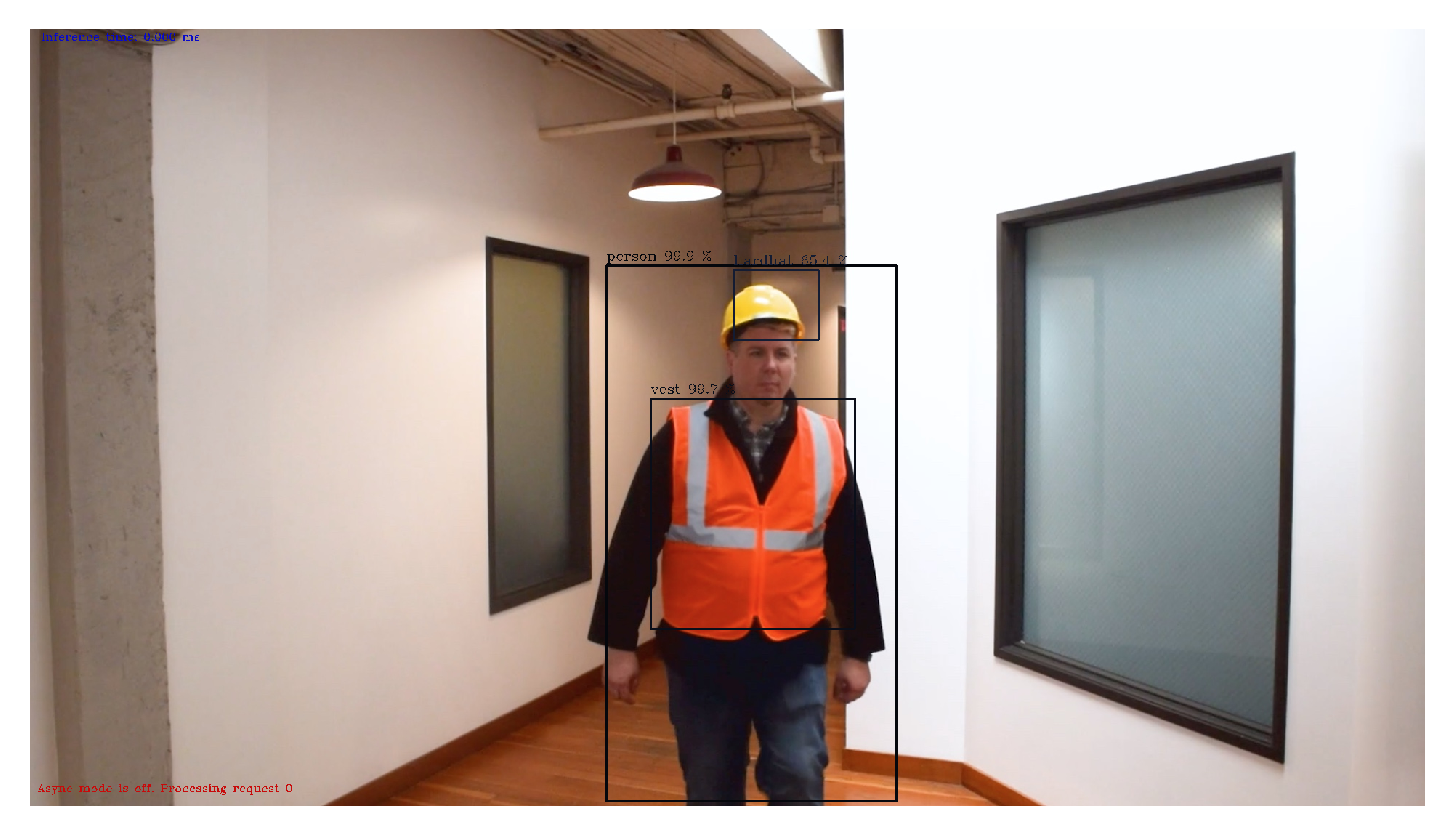

In [11]:
# For labeling the image
from out_process import placeBoxes


# Request id to keep track of
def runInference():
    plugin = createPlugin(device='CPU', extension_list=['/data/reference-sample-data/extension/libcpu_extension.so'])
    model_xml = "models/mobilenet-ssd/FP32/mobilenet-ssd.xml"
    model_bin = "models/mobilenet-ssd/FP32/mobilenet-ssd.bin"
    net = createNetwork(model_xml, model_bin, plugin)
    exec_net,input_blob,out_blob = loadNetwork(plugin, net)
    in_frame,original_frame = preprocessImage('/data/reference-sample-data/safety-gear-detection/safety-gear-image.jpg', net, input_blob)
    
    my_request_id=0

    # Starting the inference in async mode, which starts the inference in parallel
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]

        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        prob_threshold = 0.5  # 50% confidence needed for "detection"
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]
        labels = "/data/reference-sample-data/safety-gear-detection/labels.txt"
        frame = placeBoxes(res, labels, prob_threshold, original_frame, initial_w, initial_h, False, my_request_id, 0)
        # We use pyplot because it plays nicer with Jupyter Notebooks
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")
runInference()

## Step 2 : Inference on a video

Now that we know how to run inference on a single frame, let's extend this to multiple frames.
This part is already implemented in 
<a href="object_detection_demo_ssd_async.py">object_detection_demo_ssd_async.py</a>.
Most of the code is just an extension of the single frame example, but there are few points of importance that we highlight here.

The following lines determine the source of the video. We will use a pre-recorded input video file in this example, we could also use a camera by setting the input argument to 'cam'.
```python
if args.input == 'cam':
        input_stream = 0
        out_file_name = 'cam'
    else:
        input_stream = args.input
```
We capture frames from the video sample using **OpenCV VideoCapture** API.

```python
cap = cv2.VideoCapture(input_stream)
```

Finally, we have a latency masking scheme, where we post-process a frames while another frame is being processed on the inference engine.

```python
cur_request_id = 0
next_request_id = 1

while cap.isOpened():
   # ... load next frame from cap ...

   # start the next frame
   exec_net.start_async(request_id=next_request_id, inputs={input_blob: in_frame})

   # see if the current frame is ready
   if exec_net.requests[cur_request_id].wait(-1) == 0:
       # ... post-processing current frame ...
    
   # swap request ids
   cur_request_id, next_request_id = next_request_id, cur_request_id
```

The python code takes in command line arguments for video, model etc.

he Python code takes in command line arguments for video, model etc.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH="/data/reference-sample-data"
python3 object_detection_demo_ssd_async.py -m ${SAMPLEPATH}/models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i $INPUT_FILE \
                                           -o $RESULTS_PATH \
                                           -d $DEVICE \
                                           -nireq $NUM_INFER_REQS \
                                           -ce ${SAMPLEPATH}/extension/libcpu_extension.so
```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the **mobilenet-ssd** pre-trained model which has been pre-processed using the **model optimizer**
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, OpenVINO's Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, SqueezeNet* etc.,)    

* -i location of the input video stream (video/cars_1900.mp4)
* -o location where the output file with inference needs to be stored. (results/core or results/xeon or results/gpu)
* -d Type of Hardware Acceleration (CPU or GPU or MYRIAD or HDDL or FPGA)
* -nireq Number of inference requests running in parallel
* -ce Absolute path to the shared library and is currently optimized for core/xeon (extension/libcpu_extension.so)

### 2.1 Creating job file

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel® Xeon® Scalable processor, where the Notebook is allocated a single core. 
To run inference on the entire video, we need more compute power.
We will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute node that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "object_detection_job.sh"

In [12]:
%%writefile object_detection_job.sh

ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 object_detection_demo_ssd_async.py  -m ${SAMPLEPATH}/models/mobilenet-ssd/${FP_MODEL}/${NN_MODEL} \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS \
                                            -ce /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so \
                                            --labels /data/reference-sample-data/safety-gear-detection/labels.txt

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION

Writing object_detection_job.sh




#### Setup the output video specs:


After running the object detection code, we have a list of bounding boxes for the detected objects. This may be the end of the object detection workflow some applications that just need the locations, sizes and types of the detected objects. However, if a human needs to view the output video stream, we may want to produce an output video where the bounding boxes are drawn on top of the detected objects.

We treat video rendering as a separate task, which is invoked by ROI_writer at the end of our job. If you don't want to spend a long time rendering the video, you can reduce the output video quality using the SKIP_FRAME and RESOLUTION variables:

* SKIP_FRAME=1 will write all processed video frames with bounding boxes into the output video (this is the slowest option and it preserves all inference data in the output video stream)
* SKIP_FRAME=2 will write only every other frames into the output video 
* RESOLUTION=1 will produce the output video with the same resolution as the input video (this is the slowest option)
* RESOLUTION<1 will reduce the output video desolution (e.g., RESOLUTION=0.5 will set the output video resolution in each dimension to 50% of the input video)

### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit object_detection_job to 5 different types of edge compute nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [object_detection_job.sh](object_detection_job.sh) takes in 4 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU,GPU,MYRIAD, HDDl, HETERO:FPGA,CPU)
3. the floating precision to use for inference
4. the path to the input video

The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [13]:
!pbsnodes | grep compnode | sort | uniq -c

     35      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,1gbe
     18      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     15      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     23      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
     10      properties = compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     16      properties = compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
      1      properties = compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe
      1      properties = compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1gbe
     15      properties = compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,ne

Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 2.3 Job queue submission

Each of the 4 cells below will submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note**: You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

**Note** :If you want to use your own video, Change the environment variable 'VIDEO' in the following cell from "/data/reference-sample-data/safety-gear-detection/Safety_Full_Hat_and_Vest.mp4" to the full path of your uploaded video.




In [14]:
os.environ["VIDEO"] = "/data/reference-sample-data/safety-gear-detection/Safety_Full_Hat_and_Vest.mp4"

#### Submitting to an edge compute node with an Intel CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [15]:
#Submit job to the queue
job_id_core = !qsub object_detection_job.sh -l nodes=1:skylake -F "-r results/ -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_core[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_core[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_core[0]), "Rendering", 0, 100)

789.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel Xeon CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [ ]:
#Submit job to the queue
job_id_xeon = !qsub object_detection_job.sh -l nodes=1:kaby-lake -F "-r results/ -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_xeon[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_xeon[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_xeon[0]), "Rendering", 0, 100)

#### Submitting to an edge compute node with Intel Core CPU and using the onboard Intel GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [ ]:
#Submit job to the queue
job_id_gpu = !qsub object_detection_job.sh -l nodes=1:intel-hd-p530 -F "-r results/ -d GPU -f FP32 -i $VIDEO -n 4" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_gpu[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_gpu[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_gpu[0]), "Rendering", 0, 100)

#### Submitting to an edge compute node with  IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [ ]:
#Submit job to the queue
job_id_fpga = !qsub object_detection_job.sh -l nodes=1:idc003a10:iei-mustang-f100-a10 -F "-r results/ -d HETERO:FPGA,CPU -f FP32 -i $VIDEO -n 4" -N obj_det_fpga
print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_fpga[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_fpga[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_fpga[0]), "Rendering", 0, 100)

#### Submitting to an edge compute node with Intel NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [ ]:
#Submit job to the queue
job_id_ncs2 = !qsub object_detection_job.sh -l nodes=1:intel-ncs2 -F "-r results/ -d MYRIAD -f FP16 -i $VIDEO -n 8" -N obj_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_ncs2[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_ncs2[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_ncs2[0]), "Rendering", 0, 100)

### IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [ ]:
#Submit job to the queue
job_id_hddlr = !qsub object_detection_job.sh -l nodes=1:idc002mx8:iei-mustang-v100-mx8 -F "-r results/ -d HDDL -f FP16 -i $VIDEO -n 128" -N obj_det_hddlr
print(job_id_hddlr[0]) 
#Progress indicators
if job_id_hddlr:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_hddlr[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_hddlr[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_hddlr[0]), "Rendering", 0, 100)

#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [ ]:
#Submit job to the queue
job_id_up2 = !qsub object_detection_job.sh -l nodes=1:up-squared -F "-r results/ -d GPU -f FP32 -i $VIDEO -n 2" -N obj_det_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_up2[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_up2[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_up2[0]), "Rendering", 0, 100)

### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [ ]:
liveQstat()

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs and video rendering complete before proceeding to the next step.

## While you wait...

### Why do we have three progress indicators for every job? 

In a real-life inference application, the video processing pipeline may have these phases:

1. Preprocessing (such as video decoding, frame capture from camera, or fetching a frame from a network, resizing, cropping, contrast normalization, etc.) The performance of this phase will often depend on the CPU, storage, and networking speed.
2. Inference (running a neural network forward propagation procedure). The performance of inference depends mostly on the compute device (CPU or an accelerator).
3. Postprocessing (feeding data into the next pipeline stage, writing to file, sending it to a database, or even encoding a new video for a human viewer). This phase will often use the CPU, storage, or network, and will not use an accelerator.

In our demonstration samples, we separate these three phases into separate workloads. This separation allows you to independently judge the relative impact of each phase and draw conclusions for your applications. 

### What does it mean for my application?

Your application may have more or less pre/post-processing work depending on how you get your data (from storage, sensor or network), what is the resolution of your raw data, is it encoded or not, whether you need to produce an output video, etc. Therefore, you need to understand how your processing pipeline relates to this demo before drawing conclusions on performance.

In this demo, we provide three performance numbers for each architecture. However, they are not hard limits on the solution's performance. You need to relate these numbers and code to what you are doing in your own project.

### The total time is not necessarily equal to the sum of the parts

It is important to realize that in a real-life application, you may want to fuse preprocessing, inference, and postprocessing, as opposed to separating them as we did here. Fused preprocessing has several advantages:
* If inference is run asynchronously on the accelerator, the rest of the system is free for preprocessing future frames or postprocessing past frames. This allows you to mask the pre/post processing time behind inference time. 
* With fused preprocessing, inference and postprocessing, your pipeline has better data locality, allowing you to reuse data in the caches, in the application's memory, or in the hard drive cache. 



## Step 3: View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`obj_det_{type}.o{JobID}`

`obj_det_{type}.e{JobID}`

(here, obj_det_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook.

In [16]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/output_{}.mp4'.format(job_id_core[0])], 
          'results/stats_{}.txt'.format(job_id_core[0]))

In [ ]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/output_{}.mp4'.format(job_id_xeon[0])],
          'results/stats_{}.txt'.format(job_id_xeon[0]))

In [ ]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/output_{}.mp4'.format(job_id_gpu[0])],
          'results/stats_{}.txt'.format(job_id_gpu[0]))

In [ ]:
videoHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          ['results/output_{}.mp4'.format(job_id_fpga[0])],
          'results/stats_{}.txt'.format(job_id_fpga[0]))

In [ ]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
          ['results/output_{}.mp4'.format(job_id_ncs2[0])],
          'results/stats_{}.txt'.format(job_id_ncs2[0]))

In [ ]:
videoHTML('IEI Tank + IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))',
          ['results/output_{}.mp4'.format(job_id_hddlr[0])],
          'results/stats_{}.txt'.format(job_id_hddlr[0]))

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/output_{}.mp4'.format(job_id_up2[0])],
          'results/stats_{}.txt'.format(job_id_up2[0]))

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/stats_job_id_{ARCH}.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

In [ ]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('hddlr', ' IEI Mustang\nV100-MX8\nVPU'),
             ('ncs2', 'Intel\nNCS2'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/stats_'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )